October 2, 2019  
Peter Meleney  
DATA 512  

## Purpose of Notebook

This Jupyter Notebook was created by Peter Meleney on October 2, 2019.  It is meant to satisfy **Assignment A1: Data Curation** for course DATA 512: Human Centered Data Science at the University of Washington Master's of Science in Data Science (MSDS) program.

## Purpose of Assignment

From the DATA-512 Course Wikipedia page:

"The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2019. All analysis should be performed in a single Jupyter notebook and all data, documentation, and code should be published in a single GitHub repository.

The purpose of the assignment is to demonstrate that you can follow best practices for open scientific research in designing and implementing your project, and make your project fully reproducible by others: from data collection to data analysis."[1]

## Data Provenance
Raw data were gathered from the Wikimedia REST API, Wikimedia Foundation, 2018. CC-BY-SA 3.0.

Data for this project are stored on two different systems within the Wikimedia Foundation.  The first data source is the legacy so-called "pagecounts database" which "makes availabe the pagecounts aggregated per project from January 2008 through January 2016.  The main difference among pagecounts and the current pageview data is lack of filtering of self-reported bots, thus automated and human traffic are reported together [in the pagecount database]."[2] 

In [1]:
import os
import numpy as np
import pandas as pd
from urllib import request
import json
import matplotlib.pyplot as plt

#Set option to show raw numbers not in scientific notation
pd.set_option('display.float_format', lambda x: '%.0f' % x)

#Set option to show matplotlib plots in notebook
%matplotlib inline

## Make Folders for raw and clean data

In [2]:
#Make appropriate data and raw_data dirs in place.

if not os.path.exists("data/"):
    os.mkdir('data/')
    os.mkdir("data/raw_data")
    os.mkdir("data/cleaned_data")
elif not os.path.exists("data/raw_data"):
    os.mkdir('data/raw_data')
else:
    pass

if not os.path.exists("data/cleaned_data"):
    os.mkdir('data/cleaned_data')
else:
    pass

## Download raw data from Wikimedia REST API endpoints

In [3]:
#Download raw data from legacy Wikimedia REST API

print("beginning legacy file download...")
url_pagecount_all_2001010100_2019100100 = "https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/all-sites/monthly/2001010100/2019100100"
request.urlretrieve(url_pagecount_all_2001010100_2019100100, "data/raw_data/pagecounts_all_2001010100_2019100100.json")
url_pagecount_desktop_2001010100_2019100100 = "https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2001010100/2019100100"
request.urlretrieve(url_pagecount_desktop_2001010100_2019100100, "data/raw_data/pagecounts_desktop-site_2001010100_2019100100.json")
url_pagecount_mobile_2001010100_2019100100 = "https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/mobile-site/monthly/2001010100/2019100100"
request.urlretrieve(url_pagecount_mobile_2001010100_2019100100, "data/raw_data/pagecounts_mobile-site_2001010100_2019100100.json")
print("download complete.")

beginning legacy file download...
download complete.


In [4]:
#Download raw data from pageviews Wikimedia REST API

print("beginning Pageviews file download...")
url_pageviews_all_2001010100_2019100100 = "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/user/monthly/2001010100/2019100100"
request.urlretrieve(url_pageviews_all_2001010100_2019100100, "data/raw_data/pageviews_all_2001010100_2019100100.json")
url_pageviews_desktop_2001010100_2019100100 = "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/desktop/user/monthly/2001010100/2019100100"
request.urlretrieve(url_pageviews_desktop_2001010100_2019100100, "data/raw_data/pageviews_desktop_2001010100_2019100100.json")
url_pageviews_mobile_web_2001010100_2019100100 = "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-web/user/monthly/2001010100/2019100100"
request.urlretrieve(url_pageviews_mobile_web_2001010100_2019100100, "data/raw_data/pageviews_mobile-web_2001010100_2019100100.json")
url_pageviews_mobile_app_2001010100_2019100100 = "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-app/user/monthly/2001010100/2019100100"
request.urlretrieve(url_pageviews_mobile_app_2001010100_2019100100, "data/raw_data/pageviews_mobile-app_2001010100_2019100100.json")
print("download complete.")

beginning Pageviews file download...
download complete.


## Compile data from Pageviews API

In [5]:
with open('data/raw_data/pageviews_mobile-app_2001010100_2019100100.json') as file:
    pageviews_json = json.load(file)
    pageviews_mobile_app = pd.DataFrame(pageviews_json['items'])

with open('data/raw_data/pageviews_mobile-web_2001010100_2019100100.json') as file:
    pageviews_json = json.load(file)
    pageviews_mobile_web = pd.DataFrame(pageviews_json['items'])
    
with open('data/raw_data/pageviews_desktop_2001010100_2019100100.json') as file:
    pageviews_json = json.load(file)
    pageviews_desktop = pd.DataFrame(pageviews_json['items'])
    
with open('data/raw_data/pageviews_all_2001010100_2019100100.json') as file:
    pageviews_json = json.load(file)
    pageviews_all = pd.DataFrame(pageviews_json['items'])

Here we take a look at the raw data to ensure it was retrieved correctly.

In [6]:
pageviews_all.head()

,access,agent,granularity,project,timestamp,views
0,all-access,user,monthly,en.wikipedia,2015070100,7665421980
1,all-access,user,monthly,en.wikipedia,2015080100,7634815221
2,all-access,user,monthly,en.wikipedia,2015090100,7655695037
3,all-access,user,monthly,en.wikipedia,2015100100,7746031887
4,all-access,user,monthly,en.wikipedia,2015110100,7524321290


## Munge data from Pageviews API

Sum mobile web and mobile app data into a single "mobile" column

In [7]:
pageviews_mobile_all = pd.DataFrame(pageviews_mobile_web['views'] + pageviews_mobile_app['views'])
pageviews_mobile_all['timestamp'] = pageviews_mobile_web.timestamp

Replace timestamp column (string type) with timestamp type, use it as an index and the concatenate all data into a single "pageviews" dataframe

In [8]:
pageviews_all['timestamp'] = pageviews_all['timestamp'].apply(lambda x: pd.to_datetime(x[:8]))
pageviews_desktop['timestamp'] = pageviews_desktop['timestamp'].apply(lambda x: pd.to_datetime(x[:8]))
pageviews_mobile_all['timestamp'] = pageviews_mobile_all['timestamp'].apply(lambda x: pd.to_datetime(x[:8]))

pageviews_all.index = pageviews_all['timestamp']
pageviews_desktop.index = pageviews_desktop['timestamp']
pageviews_mobile_all.index = pageviews_mobile_all['timestamp']

pageviews = pd.concat([pageviews_all, pageviews_desktop, pageviews_mobile_all], axis = 1)['views']
pageviews.columns = ['pageview_all_views', 'pageview_desktop_views','pageview_mobile_views']

Take a look at the munged data

In [9]:
pageviews.head()

,pageview_all_views,pageview_desktop_views,pageview_mobile_views
timestamp,,,
2015-07-01,7665421980,4376666686,3288755294
2015-08-01,7634815221,4332482183,3302333038
2015-09-01,7655695037,4485491704,3170203333
2015-10-01,7746031887,4477532755,3268499132
2015-11-01,7524321290,4287720220,3236601070


## Pagecount Data Handling

In [10]:
with open('data/raw_data/pagecounts_all_2001010100_2019100100.json') as file:
    pagecounts_json = json.load(file)
    pagecounts_all = pd.DataFrame(pagecounts_json['items'])
    
with open('data/raw_data/pagecounts_desktop-site_2001010100_2019100100.json') as file:
    pagecounts_json = json.load(file)
    pagecounts_desktop = pd.DataFrame(pagecounts_json['items'])
    
with open('data/raw_data/pagecounts_mobile-site_2001010100_2019100100.json') as file:
    pagecounts_json = json.load(file)
    pagecounts_mobile = pd.DataFrame(pagecounts_json['items'])

Take a look at the raw data

In [11]:
pagecounts_desktop.head()

,access-site,count,granularity,project,timestamp
0,desktop-site,2998331524,monthly,en.wikipedia,2007120100
1,desktop-site,4930902570,monthly,en.wikipedia,2008010100
2,desktop-site,4818393763,monthly,en.wikipedia,2008020100
3,desktop-site,4955405809,monthly,en.wikipedia,2008030100
4,desktop-site,5159162183,monthly,en.wikipedia,2008040100


Replace timestamp column (string type) with timestamp type, use it as an index and the concatenate all data into a single "pagecounts" dataframe


In [12]:
pagecounts_all['timestamp'] = pagecounts_all['timestamp'].apply(lambda x: pd.to_datetime(x[:8]))
pagecounts_desktop['timestamp'] = pagecounts_desktop['timestamp'].apply(lambda x: pd.to_datetime(x[:8]))
pagecounts_mobile['timestamp'] = pagecounts_mobile['timestamp'].apply(lambda x: pd.to_datetime(x[:8]))

pagecounts_all.index = pagecounts_all['timestamp']
pagecounts_desktop.index = pagecounts_desktop['timestamp']
pagecounts_mobile.index = pagecounts_mobile['timestamp']

pagecounts = pd.concat([pagecounts_all, pagecounts_desktop, pagecounts_mobile], axis = 1)['count']
pagecounts.columns = ['pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views']

Take a look at the munged dataframe

In [13]:
pagecounts.head()

,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views
timestamp,,,
2007-12-01,2998331524,2998331524,nan
2008-01-01,4930902570,4930902570,nan
2008-02-01,4818393763,4818393763,nan
2008-03-01,4955405809,4955405809,nan
2008-04-01,5159162183,5159162183,nan


## Combined DataFrame Handling

Fill NAN with 0 as per instructions, define year and month rows, rearrange columns for appropriate storage as csv, store month and year as ints.

In [14]:
df = pd.concat([pagecounts, pageviews], axis =1).fillna(0)

df['year'] = df.index.year
df['month'] = df.index.month

df = df[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

df['year'] = df['year'].apply(lambda x: int(x))
df['month'] = df['month'].apply(lambda x: int(x))

Rearrange df to store row-wise instead of column-wise.

In [15]:
if df.shape[1] < df.shape[0]:
    df=df.T
else:
    pass

Take a look at the finished dataframe before csv storage.

In [16]:
df.iloc[:,:5]

timestamp,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00
year,2007,2008,2008,2008,2008
month,12,1,2,3,4
pagecount_all_views,2998331524,4930902570,4818393763,4955405809,5159162183
pagecount_desktop_views,2998331524,4930902570,4818393763,4955405809,5159162183
pagecount_mobile_views,0,0,0,0,0
pageview_all_views,0,0,0,0,0
pageview_desktop_views,0,0,0,0,0
pageview_mobile_views,0,0,0,0,0


## Store data as cleaned .csv file

In [17]:
#Store df as a csv file in cleaned_data folder
df.to_csv('data/cleaned_data/en-wikipedia_traffic_200712-201809.csv', header=False)

## Read data from cleaned_data folder

In [18]:
#Read data from cleaned data file storage
df = pd.read_csv('data/cleaned_data/en-wikipedia_traffic_200712-201809.csv', header=None, index_col=0)

## Preperation for Plotting

In [19]:
#Take a look at the data as it exists
df.iloc[:,0:5]

,1,2,3,4,5
0,,,,,
year,2007,2008,2008,2008,2008
month,12,1,2,3,4
pagecount_all_views,2998331524,4930902570,4818393763,4955405809,5159162183
pagecount_desktop_views,2998331524,4930902570,4818393763,4955405809,5159162183
pagecount_mobile_views,0,0,0,0,0
pageview_all_views,0,0,0,0,0
pageview_desktop_views,0,0,0,0,0
pageview_mobile_views,0,0,0,0,0


Here I wrote a quick function to help when creating a date row which will be used for plotting.  The pd.to_datetime function expects a two character string for the month, but when ints are converted directly to strings values less than 10 are converted into one character strings.  This function forces values less than 10 to have a leading zero, fixing this issue.

In [20]:
# Function to add leading 0 to month when converted from int to string in preperation for 
def month_to_two_digit_string(month_int):
    if month_int < 10:
        return '0'+str(int(month_int))
    else:
        return str(int(month_int))

Create a date row with type timestamp.

In [21]:
df.loc['date'] = df.loc['year'].apply(lambda x: str(int(x))) + df.loc['month'].apply(lambda x: month_to_two_digit_string(x)) +'01'
df.loc['date'] = df.loc['date'].apply(lambda x: pd.to_datetime(x, format='%Y%m%d').date())

Take a look at the data

In [22]:
df.iloc[:,0:5]

,1,2,3,4,5
0,,,,,
year,2007,2008,2008,2008,2008
month,12,1,2,3,4
pagecount_all_views,2998331524,4930902570,4818393763,4955405809,5159162183
pagecount_desktop_views,2998331524,4930902570,4818393763,4955405809,5159162183
pagecount_mobile_views,0,0,0,0,0
pageview_all_views,0,0,0,0,0
pageview_desktop_views,0,0,0,0,0
pageview_mobile_views,0,0,0,0,0
date,2007-12-01,2008-01-01,2008-02-01,2008-03-01,2008-04-01


Replace zero values with NAN for better plotting outcomes.

In [23]:
df = df.replace(0, np.nan)

## Plotting

The last month of reported values for the pagecount API are very low but not zero.  They have been excluded from this plot for clarity.

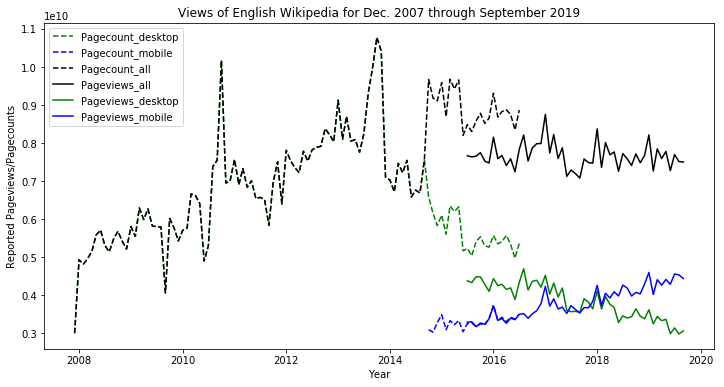

In [24]:
plt.figure(figsize=(12,6))
plt.title("Views of English Wikipedia for Dec. 2007 through September 2019")
plt.xlabel('Year')
plt.ylabel("Reported Pageviews/Pagecounts")
plt.plot(df.loc['date'].iloc[:-38], df.loc['pagecount_desktop_views'].iloc[:-38], '--', color='g', label="Pagecount_desktop")
plt.plot(df.loc['date'].iloc[:-38], df.loc['pagecount_mobile_views'].iloc[:-38], '--', color='b', label="Pagecount_mobile")
plt.plot(df.loc['date'].iloc[:-38], df.loc['pagecount_all_views'].iloc[:-38], '--', color='k', label="Pagecount_all")
plt.plot(df.loc['date'], df.loc['pageview_all_views'], color = 'k', label="Pageviews_all")
plt.plot(df.loc['date'], df.loc['pageview_desktop_views'], color = 'g', label="Pageviews_desktop")
plt.plot(df.loc['date'], df.loc['pageview_mobile_views'], color = 'b', label="Pageviews_mobile")
plt.legend(loc='upper left')

plt.savefig('English_Wikipedia_Views_12_2007-09_2019.png')

References:

[1] Morgan, Johnathan T. (2019, October 1)  Human Centered Data Science (Fall 2019)/Assignments.  Retrieved from: https://wiki.communitydata.science/Human_Centered_Data_Science_(Fall_2019)/Assignments, accessed on October 2, 2019.

[2] (27 June 2018) Analytics/AQS Legacy Pagecounts. Retrieved from: https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts, accessed on October 2, 2019.